In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf    
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input            
from tqdm import tqdm

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_dict = {class_name:i for i, class_name in enumerate(class_names)}
IMAGE_SIZE = (150, 150)

In [ ]:
def load_data():
    
    datasets_path = ['/content/drive/MyDrive/DATA/seg_train', '/content/drive/MyDrive/DATA/seg_test']
    output = []

    for dataset in datasets_path:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        for folder in os.listdir(dataset):
            label = class_names_dict[folder]
            
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Loading /content/drive/MyDrive/DATA/seg_train


100%|██████████| 2271/2271 [00:48<00:00, 46.79it/s] 


Loading /content/drive/MyDrive/DATA/seg_test


100%|██████████| 510/510 [00:05<00:00, 92.97it/s] 


Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


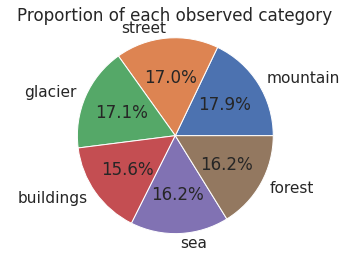

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
plt.pie(train_counts, explode=(0, 0, 0, 0, 0, 0) , labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

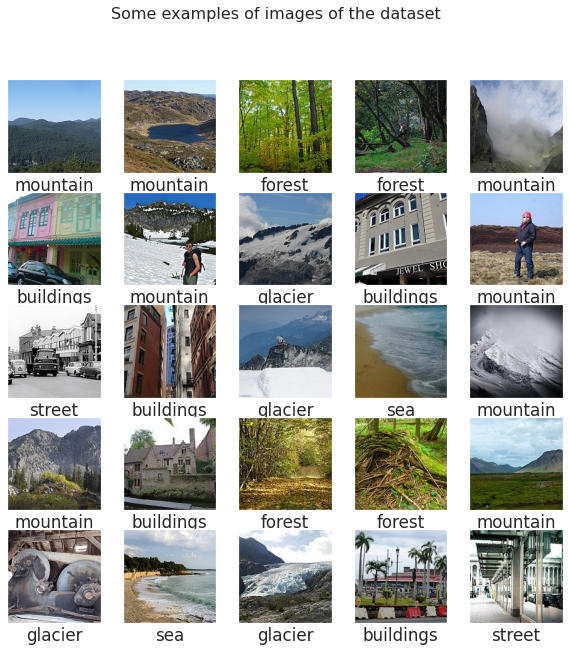

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

def display_examples(class_names, images, labels):

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

display_examples(class_names, train_images, train_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 382s 4s/step - loss: 1.3152 - accuracy: 0.5292 - val_loss: 0.9201 - val_accuracy: 0.6395
Epoch 2/20
88/88 [==============================] - 395s 5s/step - loss: 0.8403 - accuracy: 0.6868 - val_loss: 0.7969 - val_accuracy: 0.7100
Epoch 3/20
88/88 [==============================] - 395s 5s/step - loss: 0.6286 - accuracy: 0.7722 - val_loss: 0.6682 - val_accuracy: 0.7606
Epoch 4/20
88/88 [==============================] - 394s 4s/step - loss: 0.4918 - accuracy: 0.8283 - val_loss: 0.6658 - val_accuracy: 0.7688
Epoch 5/20
88/88 [==============================] - 383s 4s/step - loss: 0.3667 - accuracy: 0.8737 - val_loss: 0.6458 - val_accuracy: 0.7830
Epoch 6/20
88/88 [==============================] - 399s 5s/step - loss: 0.2402 - accuracy: 0.9218 - val_loss: 0.7886 - val_accuracy: 0.7499
Epoch 7/20
88/88 [==============================] - 395s 4s/step - loss: 0.1687 - accuracy: 0.9507 - val_loss: 0.7740 - val_accuracy: 0.7702
Epoch 8/20
88

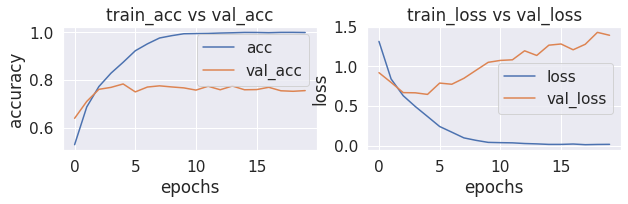

In [ ]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "acc")
    plt.plot(history.history['val_accuracy'], label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

plot_accuracy_loss(history)

In [ ]:
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1)
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 27s 286ms/step - loss: 1.3858 - accuracy: 0.7557


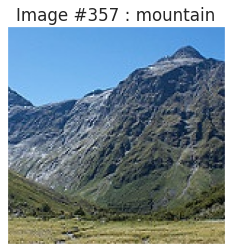

In [ ]:
def display_random_image(class_names, images, labels):
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()


display_random_image(class_names, test_images, pred_labels)

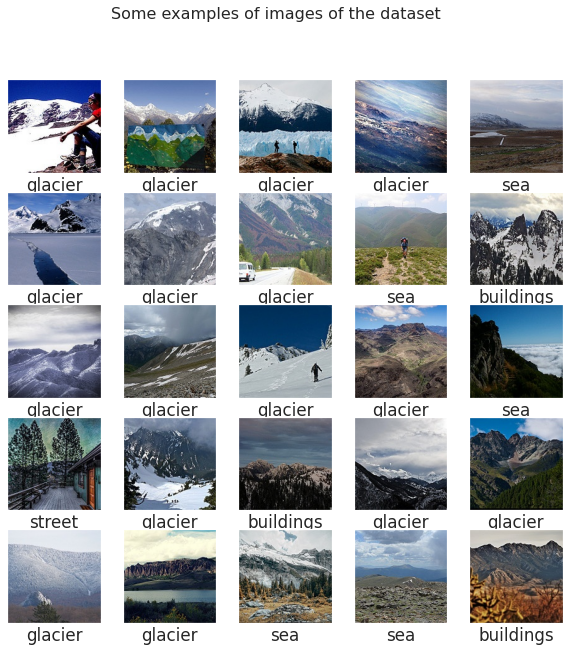

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


print_mislabeled_images(class_names, test_images, test_labels, pred_labels)


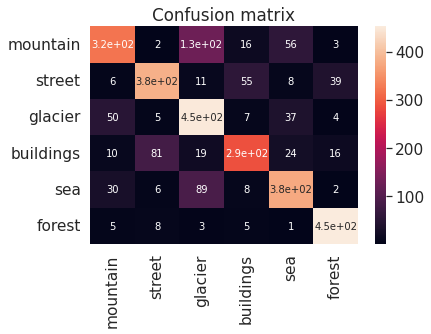

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
model_regularize = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.Dropout( 0.2), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.Dropout( 0.2), 
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_regularize.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_regularize.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 412s 5s/step - loss: 2.0242 - accuracy: 0.5270 - val_loss: 1.3779 - val_accuracy: 0.6395
Epoch 2/20
88/88 [==============================] - 412s 5s/step - loss: 1.2484 - accuracy: 0.6574 - val_loss: 1.1805 - val_accuracy: 0.6854
Epoch 3/20
88/88 [==============================] - 418s 5s/step - loss: 1.1051 - accuracy: 0.6989 - val_loss: 1.1122 - val_accuracy: 0.7089
Epoch 4/20
88/88 [==============================] - 412s 5s/step - loss: 1.0498 - accuracy: 0.7265 - val_loss: 1.0472 - val_accuracy: 0.7503
Epoch 5/20
88/88 [==============================] - 398s 5s/step - loss: 1.0107 - accuracy: 0.7285 - val_loss: 1.0407 - val_accuracy: 0.7371
Epoch 6/20
88/88 [==============================] - 415s 5s/step - loss: 0.9887 - accuracy: 0.7323 - val_loss: 0.9305 - val_accuracy: 0.7809
Epoch 7/20
88/88 [==============================] - 415s 5s/step - loss: 0.9474 - accuracy: 0.7457 - val_loss: 1.0167 - val_accuracy: 0.7178
Epoch 8/20
88

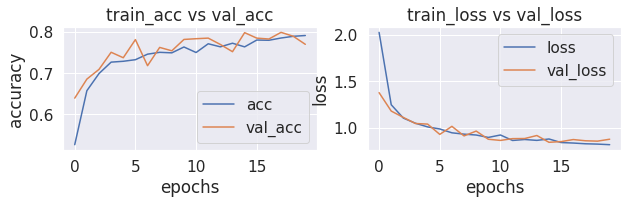

In [ ]:
plot_accuracy_loss(history)

In [ ]:
predictions_1 = model_regularize.predict(test_images)     
pred_labels_1 = np.argmax(predictions_1, axis = 1)
test_loss_1 = model_regularize.evaluate(test_images, pred_labels_1)

94/94 [==============================] - 27s 283ms/step - loss: 0.6341 - accuracy: 1.0000


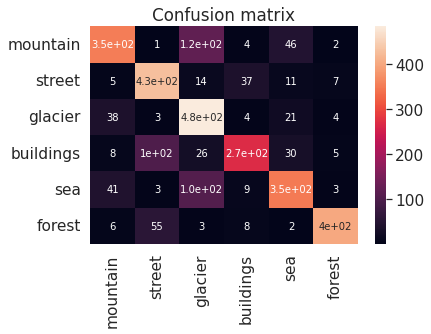

In [ ]:
CM = confusion_matrix(test_labels, pred_labels_1)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
model_vgg16 = VGG16(weights='imagenet', include_top=False)

train_features = model_vgg16.predict(train_images)
test_features = model_vgg16.predict(test_images)

n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape

24/94 [======>.......................] - ETA: 10:14

In [ ]:
model_2_vgg16  = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_2_vgg16.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history3 = model_2_vgg16.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 4s 32ms/step - loss: 0.5635 - accuracy: 0.7917 - val_loss: 0.3827 - val_accuracy: 0.8625
Epoch 2/15
88/88 [==============================] - 3s 30ms/step - loss: 0.3112 - accuracy: 0.8879 - val_loss: 0.3657 - val_accuracy: 0.8742
Epoch 3/15
88/88 [==============================] - 2s 21ms/step - loss: 0.2452 - accuracy: 0.9171 - val_loss: 0.3323 - val_accuracy: 0.8789
Epoch 4/15
88/88 [==============================] - 2s 19ms/step - loss: 0.2154 - accuracy: 0.9248 - val_loss: 0.3432 - val_accuracy: 0.8814
Epoch 5/15
88/88 [==============================] - 2s 18ms/step - loss: 0.1763 - accuracy: 0.9426 - val_loss: 0.3644 - val_accuracy: 0.8778
Epoch 6/15
88/88 [==============================] - 2s 19ms/step - loss: 0.1457 - accuracy: 0.9523 - val_loss: 0.3394 - val_accuracy: 0.8896
Epoch 7/15
88/88 [==============================] - 2s 20ms/step - loss: 0.1253 - accuracy: 0.9623 - val_loss: 0.3902 - val_accuracy: 0.8700
Epoch 8/15
88

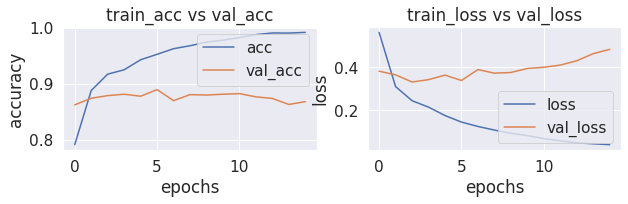

In [ ]:
plot_accuracy_loss(history3)

In [ ]:
model_regularize_vgg16  = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    tf.keras.layers.Dropout( 0.2),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_regularize_vgg16.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history4 = model_regularize_vgg16.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 3s 23ms/step - loss: 1.1240 - accuracy: 0.7438 - val_loss: 0.6185 - val_accuracy: 0.8693
Epoch 2/15
88/88 [==============================] - 2s 18ms/step - loss: 0.6226 - accuracy: 0.8473 - val_loss: 0.5231 - val_accuracy: 0.8671
Epoch 3/15
88/88 [==============================] - 2s 19ms/step - loss: 0.5299 - accuracy: 0.8664 - val_loss: 0.4897 - val_accuracy: 0.8785
Epoch 4/15
88/88 [==============================] - 2s 26ms/step - loss: 0.5129 - accuracy: 0.8642 - val_loss: 0.4845 - val_accuracy: 0.8753
Epoch 5/15
88/88 [==============================] - 3s 29ms/step - loss: 0.5032 - accuracy: 0.8637 - val_loss: 0.4954 - val_accuracy: 0.8653
Epoch 6/15
88/88 [==============================] - 2s 28ms/step - loss: 0.4723 - accuracy: 0.8792 - val_loss: 0.4741 - val_accuracy: 0.8810
Epoch 7/15
88/88 [==============================] - 2s 20ms/step - loss: 0.4766 - accuracy: 0.8733 - val_loss: 0.4811 - val_accuracy: 0.8728
Epoch 8/15
88

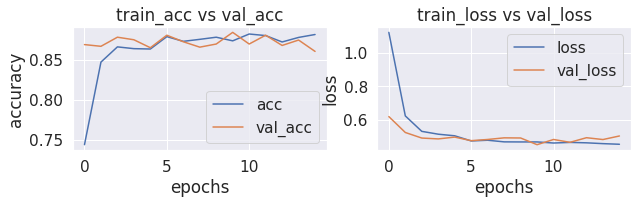

In [ ]:
plot_accuracy_loss(history4)

In [ ]:
predictions_vgg16 = model_regularize_vgg16.predict(test_images)     
pred_labels_vgg16 = np.argmax(predictions_vgg16, axis = 1)
test_loss_vgg16 = model_regularize_vgg16.evaluate(test_images, pred_labels_vgg16)

In [ ]:
CM = confusion_matrix(test_labels, pred_labels_vgg16)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "acc")
    plt.plot(history.history['val_accuracy'], label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'], label = "loss")
    plt.plot(history.history['val_loss'], label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()